In [1]:
## Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy.stats import linregress

In [2]:
## Read files and data clean
def read_satellite_data(satellite):
    # --- Main Execution ---
    df_satellite = pd.read_csv(f'../data/satellite_data/tables/phenology_climate/{satellite}.csv')
    veg_class = pd.read_csv('../data/veg_class_data/tables/veg_class.csv')
    
    df = pd.merge(df_satellite, veg_class, on=['latitude', 'longitude'], how='inner')
    df = df[df['veg_class'].isin([11, 12, 13, 14])]
    return df

In [4]:
## Read AVHRR data and effect size, then combine
satellite = "avhrr" 
df = read_satellite_data(satellite)

eos_cols = [col for col in df.columns if 'eos' in col]
t_cols = [col for col in df.columns if 'annual_t' in col]
p_cols = [col for col in df.columns if 'annual_p' in col]

years = [str(y) for y in range(1982, 2017)]
cols = years
# df = df[[col for col in eos_cols + t_cols + p_cols if any(y in col for y in cols)] + ['latitude', 'longitude', 'veg_class']].copy()
t_cols_df = [col for col in df.columns if 'annual_t' in col]
df[t_cols_df] = df[t_cols_df] - 273.5  # Convert temperature
df.columns = df.columns.str.replace(r'\D*(\d{4})$', lambda m: f"{m.group(0)[0:-4]}{m.group(1)}", regex=True)
df['annual_t'] = df[[col for col in df.columns if 'annual_t' in col]].mean(axis=1)
df['annual_p'] = df[[col for col in df.columns if 'annual_p' in col]].mean(axis=1)
df['eos'] = df[[col for col in df.columns if 'eos' in col]].mean(axis=1)
df_climate = df[['annual_t', 'annual_p', 'latitude', 'longitude', 'eos']]
# print(df_climate)
effect_size = pd.read_csv(f"../data/effect_size/avhrr/effect_size_ate.csv")
effect_size = pd.merge(effect_size, df_climate, on=['latitude', 'longitude'], how='inner')
effect_size = effect_size.rename(columns=lambda x: x.replace("w1", "82_16"))

In [5]:
## Merge effect size data
effect_size_82_00 = pd.read_csv(f"../data/effect_size/avhrr/effect_size_82_99_ate.csv")
effect_size_00_16 = pd.read_csv(f"../data/effect_size/avhrr/effect_size_00_16_ate.csv")
effect_size_82_00 = effect_size_82_00.rename(columns=lambda x: x.replace("w1", "82_99"))
effect_size_00_16 = effect_size_00_16.rename(columns=lambda x: x.replace("w1", "00_16"))
effect_size_82_00_16 = pd.merge(effect_size_82_00, effect_size_00_16, on=['latitude', 'longitude'], how='inner')
effect_size_all = pd.merge(effect_size_82_00_16, effect_size, on=['latitude', 'longitude'], how='inner')

In [ ]:
## Plot heatmap with finner temp bin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.ticker import FormatStrFormatter

def filter_extremes(df, x_col, y_col, z_col, name4, name5, name6):
    x_all = df[x_col].values
    y_all = df[y_col].values*1000
    z_all = df[z_col].values
    z_all_82_99 = df[name4].values
    z_all_00_16 = df[name5].values
    z_all_82_16 = df[name6].values

    x_low, x_high = np.nanpercentile(x_all, [0, 100])
    y_low, y_high = np.nanpercentile(y_all, [0, 100])
    mask = (x_all >= x_low) & (x_all <= x_high) & (y_all >= y_low) & (y_all <= y_high)
    return x_all[mask], y_all[mask], z_all[mask], z_all_82_99[mask], z_all_00_16[mask], z_all_82_16[mask]

def classify_data(x, y, satellite):
    # temp_class = np.where(x < np.nanmean(x), 'low temp', 'High temp')
    temp_class = np.where(x < 7.25, 'low temp', 'High temp')
    if satellite == 'avhrr':
        precip_class = np.where(y < 900, 'Low prcp', 'High prcp')
    elif satellite == 'modis':
        precip_class = np.where(y < 1000, 'Low prcp', 'High prcp')
    else:
        precip_class = np.where(y < 1000, 'Low prcp', 'High prcp')
    return temp_class, precip_class


def compute_binned_means(x, y, z, min_z_count, z_82_99, z_00_16, z_82_16):
    bin_width_x = 0.5     # 1 degree
    bin_width_y = 100     # 100 mm

    # Compute bin edges
    x_edges = np.arange(np.floor(x.min()), np.ceil(x.max()) + bin_width_x, bin_width_x)
    y_start = np.floor(y.min() / bin_width_y) * bin_width_y
    y_end = np.ceil(y.max() / bin_width_y) * bin_width_y
    y_edges = np.arange(y_start, y_end + bin_width_y, bin_width_y)

    # === Compute 2D histogram sums and counts for z ===
    z_sum, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges], weights=z)
    z_count, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges])

    # Compute mask
    valid_mask = z_count >= min_z_count

    # Compute z mean
    z_mean = np.full_like(z_sum, np.nan, dtype=np.float64)
    z_mean[valid_mask] = z_sum[valid_mask] / z_count[valid_mask]

    # === Apply same mask for z_82_99 and z_00_16 ===
    # Compute their binned means
    z82_sum, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges], weights=z_82_99)
    z00_sum, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges], weights=z_00_16)
    z82_16_sum, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges], weights=z_82_16)

    z_mean_82_99 = np.full_like(z82_sum, np.nan, dtype=np.float64)
    z_mean_00_16 = np.full_like(z00_sum, np.nan, dtype=np.float64)
    z_mean_82_16 = np.full_like(z82_16_sum, np.nan, dtype=np.float64)

    z_mean_82_99[valid_mask] = z82_sum[valid_mask] / z_count[valid_mask]
    z_mean_00_16[valid_mask] = z00_sum[valid_mask] / z_count[valid_mask]
    z_mean_82_16[valid_mask] = z82_16_sum[valid_mask] / z_count[valid_mask]

    # === Calculate bin centers ===
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2

    # === Optional diagnostics ===
    print(f'Max count of grid: {np.nanmax(z_count)}')
    print(f'Min of z_mean: {np.nanmin(z_mean)}')

    # === Return masked means and bin centers ===
    return z_mean, z_mean_82_99, z_mean_00_16, z_mean_82_16, x_centers, y_centers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize


def add_colorbar(fig, norm, z_col, vlim):
    ax_cbar = fig.add_axes([0.7, 0.55, 0.015, 0.35])
    cmap = LinearSegmentedColormap.from_list("custom_cmap",
            ["#0b3c68", "#165188", "#2066a8", "#4d91c4", "#8ec1da", 
            "#fbebe1", "#f6d6c2", "#d47264", "#c14d48", "#ae282c"])

    # norm = Normalize(vmin=np.nanmin(z_mean), vmax=np.nanmax(z_mean))

    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax_cbar)
    if vlim == (250, 305):
        cbar.set_ticks([-0.5, 0, 0.5])
    elif vlim == (235, 285):
        cbar.set_ticks([240, 260, 280])
    else:
        cbar.set_ticks([250, 270, 290])
        
    if z_col == "eos":
        # ax1.set_xlabel("EOS (DOY)", fontsize=14)
        # ax2.set_ylabel("EOS (DOY)", fontsize=14)
        cbar.ax.set_ylabel("EOS (DOY)", fontsize=14)
        cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    elif z_col == "trend_eos":
        # ax1.set_xlabel("EOS trend (DOY/year)", fontsize=14)
        # ax2.set_ylabel("EOS trend (DOY/year)", fontsize=14)
        cbar.ax.set_ylabel("EOS trend (DOY/year)", fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    
def plot_heat_map(df, x_col, y_col, z_col, name4, name5, name6, title, vlim, min_z_count, satellite):
    x_display_range = (-7, 20)
    y_display_range = (300, 1750)
    x, y, z, z_82_99, z_00_16, z_82_16 = filter_extremes(df, x_col, y_col, z_col, name4, name5, name6)
    temp_class, precip_class = classify_data(x, y, satellite)

    z_mean, z_mean_82_99, z_mean_00_16, z_mean_82_16, x_bins, y_bins = compute_binned_means(x, y, z, min_z_count, z_82_99, z_00_16, z_82_16)
    mid_x = (x_bins[:-1] + x_bins[1:]) / 2
    mid_y = (y_bins[:-1] + y_bins[1:]) / 2
    fig = plt.figure(figsize=(12, 6)) 
    plot_main_heatmap(x, y, z_mean, z_mean_82_16, z_mean_82_99, z_mean_00_16, x_col, y_col, x_bins, y_bins, x_display_range, y_display_range, vlim, satellite, title)

def plot_grid(df, name1, name2, name3, name4, name5, name6, title, vlim, min_z_count, satellite):
    plot_heat_map(df, name1, name2, name3, name4, name5, name6, title, vlim, min_z_count, satellite)

In [ ]:
## Main heatmap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap

def plot_main_heatmap(x, y, z_mean, z_82_16, z_82_99, z_00_16,
                      name1, name2, x_bins, y_bins,
                      x_display_range, y_display_range,
                      vlim, satellite, title):
    diff_vlim = (-0.5, 0.5)

    # === Base colormap for main plots ===
    cmap_main = LinearSegmentedColormap.from_list(
        "custom_cmap",
        ["#0b3c68", "#165188", "#2066a8", "#4d91c4", "#8ec1da",
         "#fbebe1", "#f6d6c2", "#d47264", "#c14d48", "#ae282c"]
    )

    # === Compute bin edges ===
    x_step = x_bins[1] - x_bins[0]
    y_step = y_bins[1] - y_bins[0]
    x_edges = np.concatenate([[x_bins[0] - x_step / 2], x_bins + x_step / 2])
    y_edges = np.concatenate([[y_bins[0] - y_step / 2], y_bins + y_step / 2])

    # === Compute normalization range for main plots ===
    datasets_main = [z_mean, z_82_16, z_82_99, z_00_16]
    vmin, vmax = vlim
    if vmin is None:
        vmin = np.nanmin([np.nanmin(z) for z in datasets_main])
    if vmax is None:
        vmax = np.nanmax([np.nanmax(z) for z in datasets_main])
    norm_main = Normalize(vmin=vmin, vmax=vmax)

    # === Compute difference dataset ===
    diff = z_00_16 - z_82_99
    cmap_diff = plt.get_cmap("RdBu_r")  # modern syntax
    norm_diff = Normalize(vmin=diff_vlim[0], vmax=diff_vlim[1])

    # === Helper function to make one plot ===
    def plot_single_heatmap(z_data, plot_title, cmap, norm, cbar_label, filename):
        fig, ax = plt.subplots(figsize=(6, 3.5))
        im = ax.imshow(z_data.T, origin='lower',
                       extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                       cmap=cmap, norm=norm, aspect='auto')

        # Axis and title
        ax.set_xlim(*x_display_range)
        ax.set_ylim(*y_display_range)
        ax.set_yticks([400, 800, 1200, 1600])
        ax.set_ylabel("MAP (mm/year)", fontsize=12)
        ax.set_xlabel("MAT (°C)", fontsize=14)

        # === Region guide lines ===
        if satellite == 'avhrr':
            ax.axhline(y=900, color='black', linestyle='--', linewidth=1.0)
            ax.vlines(x=7.25, ymin=ax.get_ylim()[0], ymax=900,
                      colors='black', linestyles='--', linewidth=1.0)
        elif satellite == 'modis':
            ax.axhline(y=1000, color='black', linestyle='--', linewidth=1.0)
            ax.vlines(x=6.75, ymin=ax.get_ylim()[0], ymax=1000,
                      colors='black', linestyles='--', linewidth=1.0)
        else:
            ax.axhline(y=1000, color='black', linestyle='--', linewidth=1.0)
            ax.vlines(x=7.25, ymin=ax.get_ylim()[0], ymax=1000,
                      colors='black', linestyles='--', linewidth=1.0)

        # === Region labels ===
        ax.text(x_display_range[1] - 0.5, y_display_range[1] - 50,
                "Wet regions", ha='right', va='top', fontsize=10, color='black')
        ax.text(x_display_range[1] - 0.5, y_display_range[0] + 50,
                "Hot-dry regions", ha='right', va='bottom', fontsize=10, color='black')
        ax.text(x_display_range[1] - 15, y_display_range[0] + 18,
                "Cold-dry regions", ha='right', va='bottom', fontsize=10, color='black')

        # === Colorbar ===
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.035, pad=0.03)
        cbar.set_label(cbar_label, fontsize=11)

        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.savefig(filename, dpi=800, bbox_inches='tight')
        plt.show()

    # === Plot each dataset separately ===
    plot_single_heatmap(
        z_82_16,
        f"{title} 1982–2016",
        cmap_main, norm_main, "Effect size",
        f"../results/ed_figures/ed_fig6-7/{title.replace(' ', '_')}_1982_2016.png"
    )

    plot_single_heatmap(
        z_82_99,
        f"{title} 1982–1999",
        cmap_main, norm_main, "Effect size",
        f"../results/ed_figures/ed_fig6-7/{title.replace(' ', '_')}_1982_1999.png"
    )

    plot_single_heatmap(
        z_00_16,
        f"{title} 2000–2016",
        cmap_main, norm_main, "Effect size",
        f"../results/ed_figures/ed_fig6-7/{title.replace(' ', '_')}_2000_2016.png"
    )

    plot_single_heatmap(
        diff,
        f"{title} Difference (2000–2016 minus 1982–1999)",
        cmap_diff, norm_diff, "ΔEffect size",
        f"../results/ed_figures/ed_fig6-7/{title.replace(' ', '_')}_difference.png"
    )



Max count of grid: 3127.0
Min of z_mean: 254.58994708994706


<Figure size 1200x600 with 0 Axes>

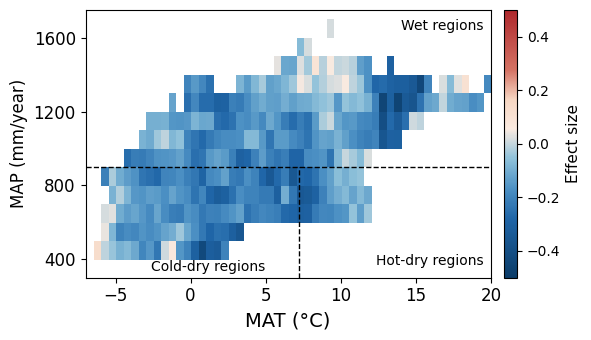

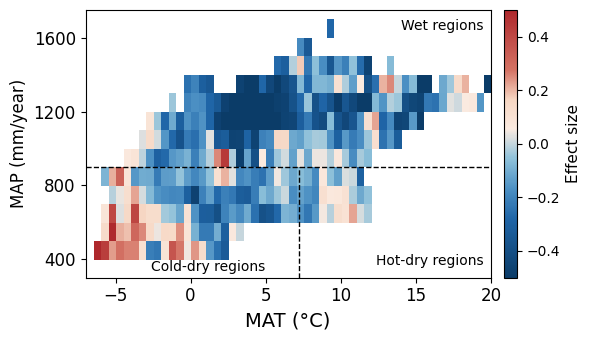

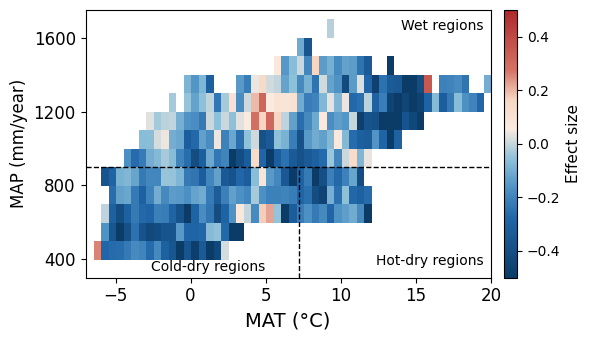

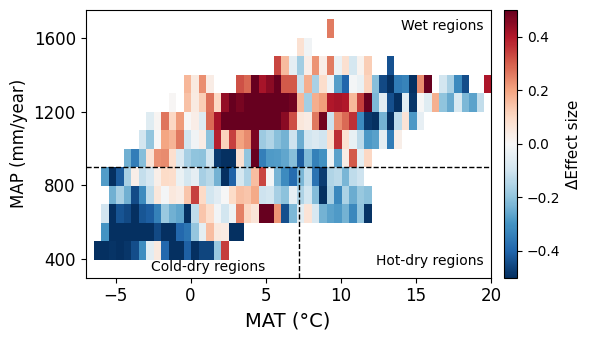

Max count of grid: 3127.0
Min of z_mean: 254.58994708994706


<Figure size 1200x600 with 0 Axes>

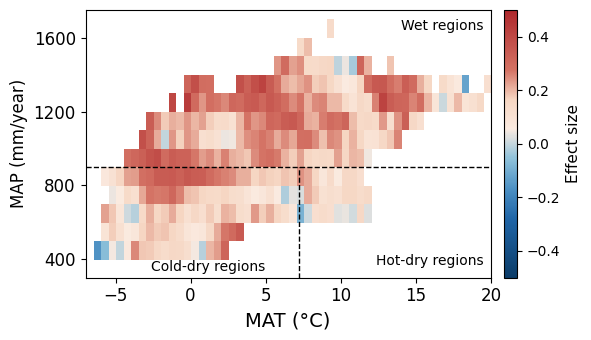

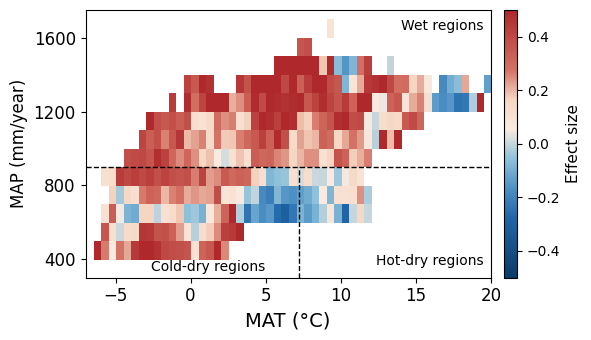

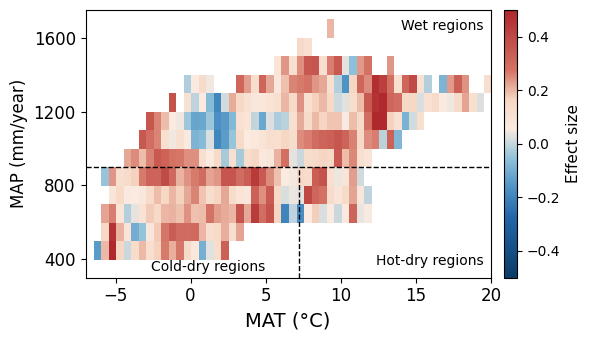

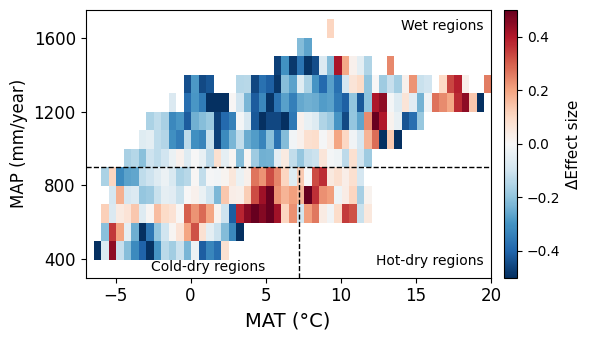

Max count of grid: 3127.0
Min of z_mean: 254.58994708994706


<Figure size 1200x600 with 0 Axes>

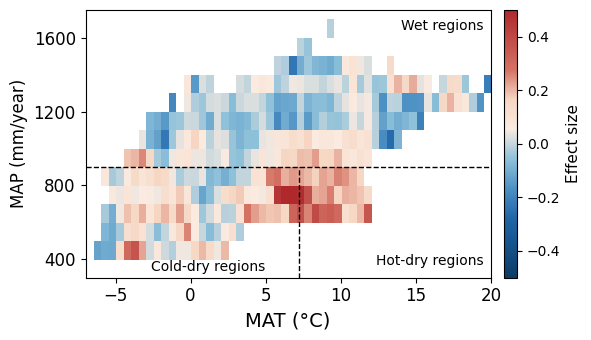

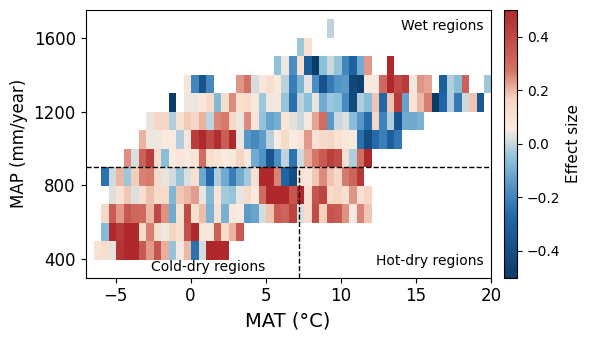

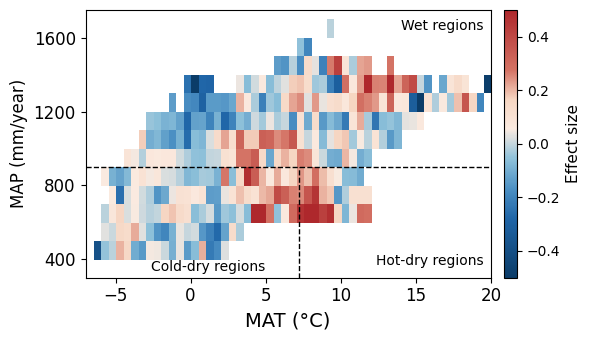

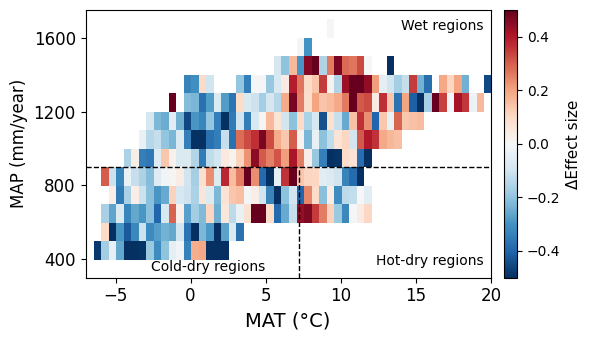

Max count of grid: 3127.0
Min of z_mean: 254.58994708994706


<Figure size 1200x600 with 0 Axes>

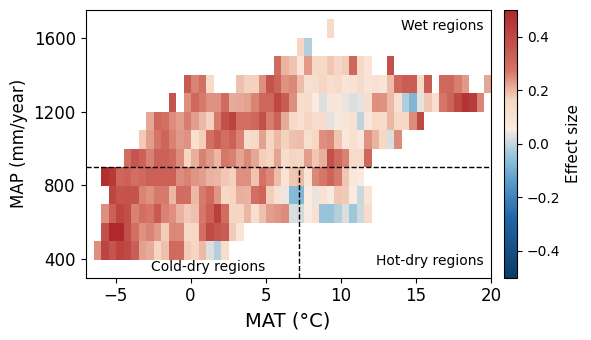

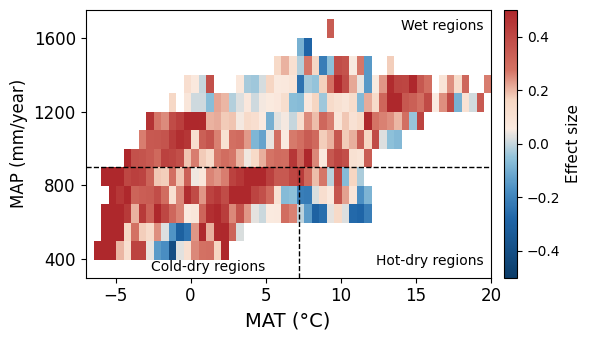

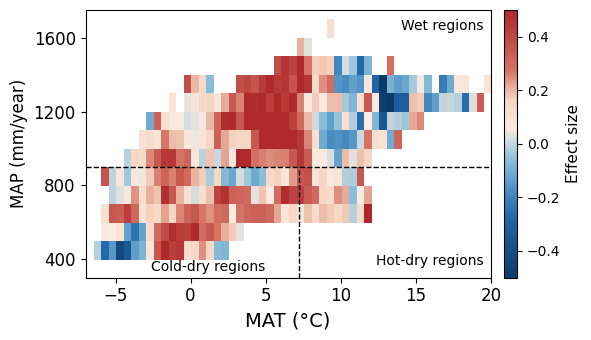

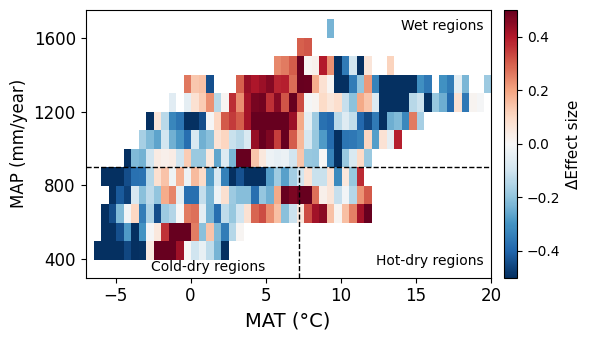

In [8]:
vmin, vmax = -0.5, 0.5
min_z_count = 50

plot_grid(effect_size_all, 'annual_t', 'annual_p', 'eos', 'spring_t_es_82_99', 'spring_t_es_00_16', 'spring_t_es_82_16', 'Spring T', (vmin, vmax), min_z_count, satellite)
plot_grid(effect_size_all, 'annual_t', 'annual_p', 'eos', 'autumn_t_es_82_99', 'autumn_t_es_00_16', 'autumn_t_es_82_16', 'Autumn T', (vmin, vmax), min_z_count, satellite)
plot_grid(effect_size_all, 'annual_t', 'annual_p', 'eos', 'summer_p_es_82_99', 'summer_p_es_00_16', 'summer_p_es_82_16', 'Summer P', (vmin, vmax), min_z_count, satellite)
plot_grid(effect_size_all, 'annual_t', 'annual_p', 'eos', 'autumn_r_es_82_99', 'autumn_r_es_00_16', 'autumn_r_es_82_16', 'Autumn SR', (vmin, vmax), min_z_count, satellite)